## CNN

필요한 라이브러리 임포트  
- torch.util.data.DataLoader: 데이터를 하나씩 전달하지 않고 원하는 batch size대로 묶어서 전달하거나 더 효율적인 학습을 위해 데이터를 어떤 규칙에 따라 정렬하거나 섞는 역할
- torchvision: 유명항 영상처리용 데이터셋, 모델, 이미지 변환기가 들어있는 패키지
- dataset: 데이터를 읽어오는 역할
- transforms: 불러온 이미지를 필요에 따라 변환해주는 역할

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

하이퍼 파라미터 지정
- batch_size: 배치 사이즈
- learning_rate: Learning Rate
- num_epoch: 반복 횟수

In [2]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 10

dest.MNIST: MNIST Dataset을 불러온다.  
torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=False)
- root: Root directory
- train: train Dataset(True) or test Dataset(False)
- donwload: Download(True), Not Dowload(False) and load by root file
- transform: Data(PIL Image) 변형
- target_transform: Label 변형

In [3]:
mnist_train = dset.MNIST(root="../", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST(root="../", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

0it [00:00, ?it/s]

9920512it [00:03, 2483025.24it/s]                             


Extracting ../MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:01, 29214.45it/s]                           
0it [00:00, ?it/s]

Extracting ../MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2107094.84it/s]                            
0it [00:00, ?it/s]

Extracting ../MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 13657.32it/s]            


Extracting ../MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


torch.utils.data import DataLoader에서 Data확인을 위하여 __getitem__과 __len__을 제공한다.  

__getitem__(index):
- Parameters: Index
- Returns: Tuple (image, target). target is a list of captions for the image.
- Return type: tuple

In [4]:
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
print(mnist_test.__getitem__(0)[0].size(), mnist_test.__len__())

print(len(mnist_train),len(mnist_test))
#print(mnist_train[0])

torch.Size([1, 28, 28]) 60000
torch.Size([1, 28, 28]) 10000
60000 10000


**torch.utils.data.DataLoader Parameter**  
torch.utils.data.DataLoader(
imagenet_data,
batch_size=4,
shuffle=True,
num_workers=args.nThreads)  
위에서 설명하였듯이 데이터를 배치로 보내기 위해서 사용하므로 batch인수 존재  
중요한것은 Tensorflow에는 없었던 shuffle을 지원한다는 것이다.  
Neural Network에서 마지막에 들어간 Data에 맞게 조금 더 조정되는 경향을 보이므로 Data의 순서도 생각하여 랜덤으로 섞이게 들어가게 하는 것이 조금 더 정확도를 높은 결과를 보여준다.

In [6]:
train_loader = DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=2,drop_last=True)
test_loader = DataLoader(mnist_test,batch_size=batch_size,shuffle=True,num_workers=2,drop_last=True)

하나의 Class로서 CNN Model을 만든다.  
**Conv2d Parameter**  
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')  

Tensorflow 와 다르거나 추가된 부분만 알아보자.  

- in_channels: input channel의 값
- out_channels: output의 channel의 값

**여기서 중요한 것은 Tensorflow와 같이 input, output의 size를 정하는 것이 아니라 input, output의 size를 자동으로 할당하기 때문에 여기서의 channel은 image의 흑백을 의미하는 channel이 아닌 Feature의 개수라고 생각하여야 한다.**  

- dilation: dilation convolution은 필터 내부에 zero padding을 추가해 강재로 receptive field를 늘리는 방법이다. 아래 그림에서 진한 파란 부분만 weight가 있고 나머지 부분은 0으로 채워진다.이러한 방법의 특징은 pooling을 수행하지도 않고도 receptive field를 크게 가져갈 수 있기 때문에 spatial dimension 손실이 적고 대부분의 weight가 0이기 때문에 연산의 효율이 좋다.
<p>
<img src="https://cdn-images-1.medium.com/max/1200/1*SVkgHoFoiMZkjy54zM_SUw.gif"></p>
    
위의 식은 아래와 같이 정의 된다.  
$$input size = (N, C_in, H, W)$$
$$output size = (N, C_out, H_out, W_out)$$

$$out(N_i,C_{out_j}) = bias(C_{out_j}) + \sum_{k=0}^{C_in - 1}weight(C_{out_j}, k) * input(N_i,k)$$

아래 식에서 중요한 함수는 view함수가 있다.  
nn.Linear에 값을 전달하기 위하여 Convolution의 결과의 행렬의 크기를 맞춰주어야 한다.  
현재 DataLoader를 통하여 batch_size만큼 자동으로 전달해 주고 있으므로 (batch_size, -1)을 통하여 크기를 자동으로 맞춰주는 작업을 실시한다.

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5),             
            nn.ReLU(),                                                          
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5),            
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),                               
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),          
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)    
        )
        self.fc_layer = nn.Sequential(                                          
            nn.Linear(64*3*3,100),                                              
            nn.ReLU(),
            nn.Linear(100,10)                                                   
        )       
        
    def forward(self,x):
        out = self.layer(x)                                                     
        out = out.view(batch_size,-1)                                            
        out = self.fc_layer(out)
        return out

- LossFunction: CrossEntropy
- Optimizer: Adam

아래 에서 중요한 점은 device를 정의하는 것이다.  
아래 Code를 통하여 GPU환경에서 돌릴수 있으면 돌리고 환경이 갖춰져 있지 않으면 CPU를 사용해서 Trainning하라는 의미이다.

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

정의한 반복 횟수만큼 Model을 Trainning 하는 과정이다.  

In [14]:
loss_arr =[]
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
        if j % 1000 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())

tensor(2.3077, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2803, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0991, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0606, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0980, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0873, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0928, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0537, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0246, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0242, device='cuda:0', grad_fn=<NllLossBackward>)


Loss 시각화

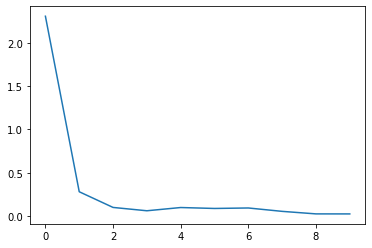

In [15]:
plt.plot(loss_arr)
plt.show()

Test Data Set으로 정확도 확인
- correct: 맞은 개수를 저장할 변수
- total: 전체 개수를 저장할 변수
- torch.no_grad(): 기울기를 계산하지 않는 상태에서 테스트를 진행한다는 의미이다. 이런 상황에서 테스트를 진행하게 되면 계속해서 Model을 Trainning하면서 결과를 확인하게 되므로 측정하고자 하는 Model의 상태에서 Test하는 환경이 아니다.
- torch.max(output,1): Test진행 후 Model에서 최대값과 Index를 구하는 작업
- label.size(0): 현재 Model은 Batch로 처리하고 있기 때문에 Batch Size만큼을 반환하기 위해서 선언

In [16]:
correct = 0
total = 0

# 인퍼런스 모드를 위해 no_grad 해줍니다.
with torch.no_grad():
    # 테스트로더에서 이미지와 정답을 불러옵니다.
    for image,label in test_loader:
        
        # 두 데이터 모두 장치에 올립니다.
        x = image.to(device)
        y_= label.to(device)

        # 모델에 데이터를 넣고 결과값을 얻습니다.
        output = model.forward(x)
        
        # https://pytorch.org/docs/stable/torch.html?highlight=max#torch.max
        # torch.max를 이용해 최대 값 및 최대값 인덱스를 뽑아냅니다.
        # 여기서는 최대값은 필요없기 때문에 인덱스만 사용합니다.
        _,output_index = torch.max(output,1)
        
        # 전체 개수는 라벨의 개수로 더해줍니다.
        # 전체 개수를 알고 있음에도 이렇게 하는 이유는 batch_size, drop_last의 영향으로 몇몇 데이터가 잘릴수도 있기 때문입니다.
        total += label.size(0)
        
        # 모델의 결과의 최대값 인덱스와 라벨이 일치하는 개수를 correct에 더해줍니다.
        correct += (output_index == y_).sum().float()
    
    # 테스트 데이터 전체에 대해 위의 작업을 시행한 후 정확도를 구해줍니다.
    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 98.80809783935547%
